<center>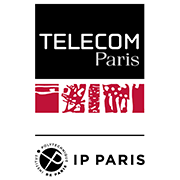</center>

<h1><center><strong><font color="green">IA 717: CHAI & fairness: linguistics of AI ethics charters & manifestos<br/>PART4 : AMR</font></strong></center></h1>

<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor</h3>
<a>Maria Boritchev</a> <email>maria.boritchev@telecom-paris.fr</email>

<h3> Project student</h3>
<a>Josephine Bernard</a> <email>josephine.bernard@telecom-paris.fr</email><br/>
<a>Laury Magne</a> <email>laury.magne@telecom-paris.fr</email><br/>
<a>Dan Hayoun</a> <email>dan.hayoun@telecom-paris.fr</email><br/>
<a>Nicolas Allègre</a> <email>nicolas.allegre@telecom-paris.fr</email><br/>


<br/>
Year 2024-2025
</center>

------------------------

# <font color="green">**0 - Code Python initial**</font>

### 0.1) Première partie imports et fonctions globales

In [17]:
# python -m pip install matplotlib numpy scipy sklearn tabulate penman

# Global import
import importlib
import itertools
import math
import os
import shutil
import sys
import string
import typing
from collections.abc import Iterable
from itertools import islice
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import penman
from scipy.stats import norm  # type: ignore[import-untyped]
from sklearn.feature_extraction.text import CountVectorizer
from tabulate import tabulate

import metamorphosed.amrdoc as amrdoc
from Corpus import Corpus

PATH_DATA_FOLDER = '../data'
PATH_LOG_FOLDER = '../log'
PATH_DATA_TXT = '../data/txts'
PATH_DATA_DOCS = '../data/docs'
PATH_DATA_PREPROCESSED = '../data/preprocessed'
PATH_DATA_CORTEX = '../data/corpus_cortext'
PATH_DATA_IRAMUTEQ = '../data/corpus_iramuteq'
PATH_DATA_AMR = '../data/AMR'
FILENAME_DATA_IRAMUTEQ = 'corpus.txt'
FILENAME_DATA_LANG = 'corpus_lang.csv'
FILENAME_DATA_LANG_PREPRO = 'corpus_lang_preprocessing.csv'
FILENAME_DATA_AMR = 'key_penmans.amr'
PATH_DATA_FILE_LANG = os.path.join(PATH_DATA_FOLDER, FILENAME_DATA_LANG)
PATH_DATA_FILE_LANG_PREPRO = os.path.join(PATH_DATA_FOLDER, FILENAME_DATA_LANG_PREPRO)
PATH_DATA_FILE_IRAMUTEQ = os.path.join(PATH_DATA_IRAMUTEQ, FILENAME_DATA_IRAMUTEQ)
PATH_DATA_FILE_AMR = os.path.join('..', FILENAME_DATA_AMR)
TYPE_METHOD = ['cortex', 'iramuteq', 'txt']
CHARSET = 'UTF-8'

sys.path.append('..')


def take(n: int, iterable: Iterable) -> list[any]:
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))
#end def take

# Chargement de tout les corpus
# list_corpus = {method: Corpus(method) for method in TYPE_METHOD}

### 0.2) Deuxième partie chargement des données

In [20]:
amr_mapaie = amrdoc.AMRdoc(PATH_DATA_FILE_AMR)

..\key_penmans.amr


1201 sentences read from ..\key_penmans.amr


# <font color="green">**4 - AMR**</font>

## **4.0) Intro et explication**

### 4.0.1) Mémo d'utilisation

##### **Variable Notebook `amr_mapaie` :**

- **`amr_mapaie`** : variable contenant le chargement du fichier AMR (classe amrdoc.AMRdoc)
  - `amr_mapaie.sentences` : liste contenant toutes les phrases en AMR (classe amrdoc.AMRsentence)
  - `amr_mapaie.sentences.tsv()` : liste de l'AMR au format Graph Penman (triplet)
    - ATTENTION : le format Graph n'est pas unique à partir d'un AMR !!!
    > *Conversion from a PENMAN string to a Tree, and vice versa, is straightforward and lossless. Conversion to a Graph, however, is potentially lossy as the same graph can be represented by different trees.*
  - `amrdoc.relations_between_concepts([amr_mapaie])` : Permet d'avoir un comptage et des stats sommaires.
    - Avec *, depth=1* comme argument, seulement les concepts
    - Avec *, depth=2* (défaut) comme argument, les stats concepts et relation associés


##### **La classe `amrdoc.AMRsentence` :**

 - `amr_mapaie.sentences[0].amr` : l'AMR de la phrase (non parsé)
 - `amr_mapaie.sentences[0].text` : la phrase de l'AMR
 - `amr_mapaie.sentences[0].comments[0]` : le numéro du fichier (Format : 'File xxx')
 - `amr_mapaie.sentences[0].tsv()` : Graph de l'AMR (même remarque)
   - égale à *penman.decode(amr_mapaie.sentences[0].amr)*
 - `amr_mapaie.sentences[0].getconceptlist()` : Retourne la liste des concept de la phrase


##### **Le module `Penman` :**

À utiliser pour plus de précision sur le parcours des graphes/arbres de la syntaxe AMR.

- https://penman.readthedocs.io/en/latest/api/penman.html
- https://penman.readthedocs.io/en/latest/api/penman.graph.html


```python
amr = amr_mapaie.sentences[0].amr
g = penman.decode(amr)
top = g.top  # Sommet de l'arbre
concepts = {}
# for s, p, o in amr_mapaie.sentences[0].tsv():
for s, p, o in g.instances():
  # s = source – the source variable of the triple (g.top est le sommet)
  # p = role – the edge label between the source and target
  # o = target – the target variable or constant => C'est le concept pour les noeuds
  if p == ":instance":
    concepts[s] = o
...
```


### 4.0.2) Aide analyse AMR

Le fichier AMR de mapaie, `key_penmans.amr` est un fichier brut pouvant être lu en texte.
- La ligne *::snt* est la phrase originelle
- Suivie du numéro de fichier*
- Suivie de la syntaxe AMR (Penman)

Normalement, il n'y a pas besoin de lire directement ce fichier, juste à utiliser la variable `amr_mapaie`.

Aide sur la syntaxe AMR : https://github.com/amrisi/amr-guidelines/blob/master/amr.md


### 4.0.3) Exemple d'utilisation dans amrdoc :

In [ ]:
def relations_between_concepts(ads, depth=2):
    output = []
    concepts = {} # {concept: {relation: {concept: freq}}}
    for ad in ads:
        for sent in ad.sentences:
            instances = {} # inst: concept
            for s, p, o in sent.tsv():
                if p == ":instance":
                    instances[s] = o
            for s, p, o in sent.tsv():
                if p != ":instance":
                    sclass = instances[s]
                    oclass = instances.get(o, "lit:" + o)

                    if depth == 1:
                        if sclass in concepts:
                            concepts[sclass] += 1
                        else:
                            concepts[sclass] = 1
                        continue

                    if sclass in concepts:
                        relations = concepts[sclass]
                    else:
                        relations = {}
                        concepts[sclass] = relations

                    if depth == 2:
                        if p in relations:
                            relations[p] += 1
                        else:
                            relations[p] = 1
                        continue

                    if p in relations:
                        objectconcepts = relations[p]
                    else:
                        objectconcepts = {}
                        relations[p] = objectconcepts
                    if oclass in objectconcepts:
                        objectconcepts[oclass] += 1
                    else:
                        objectconcepts[oclass] = 1
    for c in sorted(concepts):
        if depth == 1:
            #print(c, concepts[c], sep="\t")
            output.append("%s\t%s" % (c, concepts[c]))
            continue
        #print(c)
        output.append(c)
        for r in sorted(concepts[c]):
            if depth == 2:
                #print("   %s\t%s" % (r, concepts[c][r]))
                output.append("   %s\t%s" % (r, concepts[c][r]))
                continue
            #print("   ", r)
            output.append("   " + r)
            for oc in sorted(concepts[c][r]):
                #print("     %s\t%s" % (oc, concepts[c][r][oc]))
                output.append("     %s\t%s" % (oc, concepts[c][r][oc]))

    return output


### **4.1) Initialisation utilisation**

In [21]:
c1 = [x.split('\t') for x in amrdoc.relations_between_concepts([amr_mapaie], depth=1)]
c2=[x.split('\t') for x in amrdoc.relations_between_concepts([amr_mapaie], depth=2)]

# Concepts présents dans les AMR de mapaie
concepts = set(x[0] for x in c1)
# Type de relation présents dans les AMR de mapaie
relations = set(x[0] for x in c2) - concepts

Il faut chercher dans cette liste ceux qui se rapporte à **fairness** pour pourvoir effectuer les analyses à faire.

- Une première méthode simple est de regarder cette liste `concepts` dans la lettre 'f' :
  >'face-01', 'facet', 'facilitate-01', 'facility', 'fact', 'factor', 'factor-01', 'fail-01', 'fair-01', 'fairness', 'fairwash-01', 'fall-01', 'fall-04', 'fallacy', 'familiarize-01', 'fatality', 'feasibility', 'feature', 'feature-01', 'federate-01', 'feed-01', 'feed-02', 'feedback', 'feel-01', 'few', 'fidelity', 'field', 'fight-01', 'figure', 'fill-01', 'fill-in-05', 'find-01', 'find-02', 'fine-04', 'fire-02', 'firm', 'fit-01', 'fit-03', 'fit-06', 'fix-03', 'flaw-01', 'flexibility', 'flow-01', 'focus-01', 'follow-01', 'follow-02', 'follow-04', 'follow-through-07', 'foresee-01', 'foreword', 'forgive-01', 'form', 'form-01', 'formalize-01', 'formula', 'formulate-01', 'foster-01', 'found-01', 'foundation', 'frame', 'frame-06', 'framework', 'free-04', 'frequent-02', 'friendly-01', 'from', 'fulfill-01', 'full-09', 'fun-01', 'function', 'function-01', 'functional-03', 'fund', 'fund-01', 'furnish-01', 'fuse-01', 'future'
  - **'fair-01', 'fairness', 'fairwash-01'** pourrait nous interresser.
  - *À noter que 'fairness' n'existe pas dans les concepts de probBank*

- Une deuxième méthode serait pour chaque phrase qui ne contient pas les concepts AMR 'fair-01', 'fairness', regarder manuellement comment le mot fairness a été transcrit.


Ensuite, on pourrait se renseigner au sens des mots choisis dans les fichiers XML de probBank [lien](https://github.com/propbank/propbank-frames/tree/main/frames) (ou sur l'application metamorphosed).

In [22]:
stat_concept = dict.fromkeys(sorted(concepts), 0)
for x in c1:
    stat_concept[x[0]] = int(x[1])

stat_relation = dict.fromkeys(sorted(relations), 0)
stat_concept_relation = dict.fromkeys(sorted(concepts), {})
tmp_concept = list(stat_concept_relation.keys())[0]
for x in c2:
    if len(x) == 1 and x[0] in concepts:  # C'est un concept
        tmp_concept = x[0]
        stat_concept_relation[tmp_concept] = dict.fromkeys(sorted(relations), 0)
        continue
    
    if len(x) > 1:  # C'est une relation associé au concept précédant
        stat_relation[x[0]] += int(x[1])
        stat_concept_relation[tmp_concept][x[0]] = int(x[1])


# stat_concept : contient les stats d'utilisation des concepts
# stat_relation : contient les stats d'utilisation du type de relation
# stat_concept_relation : contient les stats d'utilisation des type de relation par concept

In [23]:
tmp = dict(sorted(stat_concept.items(), key=lambda item: item[1], reverse=True))
pprint({k: tmp[k] for i, k in enumerate(tmp) if i < 20}, sort_dicts=False)

# tmp = dict(sorted(stat_relation.items(), key=lambda item: item[1], reverse=True))
# pprint({k: tmp[k] for i, k in enumerate(tmp) if i < 20}, sort_dicts=False)

{'and': 5658,
 'name': 2995,
 'multi-sentence': 1020,
 'or': 572,
 'possible-01': 569,
 'publication-91': 395,
 'person': 379,
 'publication': 362,
 'intelligent-01': 354,
 'use-01': 354,
 'have-degree-91': 334,
 'mean-01': 305,
 'date-entity': 300,
 'principle': 278,
 'recommend-01': 257,
 'fair-01': 256,
 'develop-02': 249,
 'system': 246,
 'cause-01': 234,
 'ensure-01': 233}


In [24]:
# Première initialisation des concepts AMR liés à FAIRNESS :
list_concept_tosee = ['fair-01', 'fairness', 'fairwash-01']

# Filtre pour l'affichage
list_relation_tosee = set([y for x in list_concept_tosee for y in stat_concept_relation[x] if stat_concept_relation[x][y] != 0])
# tmp = {x: {y.strip(): stat_concept_relation[x][y] for y in list_relation_tosee} for x in list_concept_tosee}
# print(tabulate(tmp.values(), showindex=list_concept_tosee, headers='keys', tablefmt='pipe'))

tmpbis = {y.strip(): {x: stat_concept_relation[x][y] for x in list_concept_tosee} for y in list_relation_tosee}
print(tabulate(tmpbis.values(), showindex=list_relation_tosee, headers='keys', tablefmt='pipe'))


|              |   fair-01 |   fairness |   fairwash-01 |
|:-------------|----------:|-----------:|--------------:|
| :mod         |        13 |        105 |             0 |
| :polarity    |        58 |         42 |             0 |
| :topic       |         0 |         10 |             0 |
| :li          |         0 |          2 |             0 |
| :ARG0        |         5 |          0 |             1 |
| :ARG1        |       156 |          0 |             1 |
| :degree      |         1 |          0 |             0 |
| :source      |         0 |          1 |             0 |
| :prep-on     |         0 |          1 |             0 |
| :beneficiary |         0 |          2 |             0 |
| :domain      |         1 |          5 |             0 |
| :ARG3        |         1 |          1 |             0 |
| :quant       |         0 |          1 |             0 |
| :manner      |         5 |          6 |             1 |
| :location    |         3 |          5 |             0 |
| :poss       

### **4.2) Analyse à parti AMR**

Nous nous interressons au voisinage de l'utilisation du mot fairness dans le graph AMR :

<pre style='font=font-family:Courier New, Courier, monospace;'>
        =====
        = P =
        =====
         / \
  V_tag /   \ F_tag
       /     \
   =====     =====
   = V =     = F =
   =====     =====
               |
               | E_tag
               |
             -------
             |  E  |
             | ... |
             -------
</pre>
**Explications :**
- F : Le noeud où le concept de *fairness* apparait
- P : le concept parent
- V : le concept voisin, lié à *fairness* par le parent
- E : les concepts enfants
- x_tag : les tags AMR associés

### Recherche à faire :
<font color="red">Faire les statistiques puis analyser avec les précédents constats de notre analyse PosTag :
- P( P )
- P( F_tag )
- P( V )
- P( V \ P)
- P( V_tag, F_tag )
- P( E_tag )
- P( {E}=∅ ) : Fairness n'a pas d'enfant
- P( rang(E)=1 ) : Fairness n'a qu'un enfant
- P( rang(E)>1 ) : Fairness à plusieurs enfants

</font>